In [1]:
#Example of notebooks with dynamic programing
# Heavily inspired from:
#http://www.imagingshop.com/automatic-cropping-of-non-rectangular-images/

In [2]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Define a few constants:
shape = 3000,4000
nimg = 100
rot_max = numpy.radians(5) 
shift_max = 100
rotations = numpy.random.random(nimg)*(2*rot_max)-rot_max
shifts = numpy.random.random((nimg,2))*(2*shift_max)-shift_max

In [4]:
from scipy import ndimage

res = numpy.zeros(shape, dtype=numpy.int8)
data = numpy.ones_like(res)
for shift, rot in zip(shifts, rotations):
    ary = numpy.array([[numpy.cos(rot), numpy.sin(rot)],[-numpy.sin(rot), numpy.cos(rot)]])
    res+=ndimage.affine_transform(data, matrix=ary, offset=shift, order=0)
    print(rot, shift)

0.0591785294866 [-90.19046672   7.36186083]
-0.00929744182981 [ 86.5660009   10.31230813]
-0.084049351387 [ 95.82827333 -45.31920523]
0.0693471745111 [ 27.1385865  -11.10009253]
0.0803884068787 [ 21.81331825  47.1821354 ]
0.0117501088583 [-74.72553035  61.93699642]
-0.0481665140972 [-72.95252361 -82.75674375]
0.00974682282743 [ 76.26156739  -2.11594506]
-0.00193568433462 [-80.88224072 -56.27497963]
-0.0178577200466 [-80.22879938  87.91067125]
-0.00904337212063 [ 83.39445514 -95.73842915]
0.0302024703602 [ 25.61579881 -17.05998446]
0.00142357010899 [ 81.06202657  49.18203558]
0.0376344052173 [ 64.59399525 -94.6411218 ]
-0.00707851488431 [-57.91768853 -62.24148482]
-0.0523065522722 [ 28.18647233 -29.76962242]
0.0826645200886 [ 54.86766461 -54.96420996]
-0.0209666754938 [-71.27142816  79.67519057]
0.0338984933801 [ 13.85866602 -95.0301015 ]
-0.0437936438404 [-58.82033756  -6.46890647]
-0.0814752184041 [-26.13818611 -62.43457   ]
-0.0350949980064 [-11.29953522 -38.66121581]
0.0178826015084

In [5]:
fig, ax = subplots(1,2)
ax[0].imshow(res)
ax[1].imshow(res==nimg)

<IPython.core.display.Javascript object>

In [6]:
%load_ext cython

In [7]:
%%cython -a
import numpy
import cython

@cython.boundscheck(False)
def cy_square_detection(data):
    cdef:
        int width, height, i, j
        int[:,::1] res, mask
    mask = numpy.ascontiguousarray(data, numpy.int32)
    res = numpy.zeros_like(mask)
    height = mask.shape[0]
    width = mask.shape[1]
    for i in range(height):
        res[i,0] = (mask[i,0] != 0)
    for j in range(width):
        res[0,j] = (mask[0,j] != 0)
    for i in range(1, height):
        for j in range(1, width):
            if mask[i,j] != 0:
                res[i,j] = 1 + min(res[i-1, j], res[i-1, j-1], res[i, j-1])
    return numpy.asarray(res)

#Some helper function for rectangles
cdef int getsize(int width, int height):
    "search for 16/9 images"
    return 16*width + 9*height

@cython.boundscheck(False)
def cy_rectangle_detection(data):
    cdef:
        int width, height, i, j, s, square, maxsquare, maxsize, rh, rw
        int[:,::1] sizes, squares, mask, widths, heights
        int[::1] height2width
    mask = numpy.ascontiguousarray(data, numpy.int32)
    squares = cy_square_detection(mask)
    height = mask.shape[0]
    width = mask.shape[1]    
    sizes = numpy.zeros_like(mask)
    widths = numpy.zeros_like(mask)
    heights = numpy.zeros_like(mask)
    maxsquare = 0

    for i in range(height):
        for j in range(width):
            square = squares[i, j]
            sizes[i, j] = getsize(square, square)
            if square > maxsquare:
                maxsquare = square
    
    height2width = numpy.empty(maxsquare+1, numpy.int32)    
    for i in range(height):
        for k in range(maxsquare+1):
            height2width[k] = 0
        for j in range(width):
            square = squares[i, j]
            if square > 0:
                maxsize = sizes[i, j]
                for rh in range(square, 0, -1):
                    rw = height2width[rh]
                    rw = max(rw+1, square)
                    height2width[rh] = rw
                    size = getsize(rw, rh)
                    if size > maxsize:
                        maxsize = size
                        widths[i,j]=rw
                        heights[i,j]=rh
                    sizes[i,j] = maxsize
                for k in range(square+1, maxsquare+1):
                    height2width[k] = 0
    return numpy.asarray(sizes), numpy.asarray(widths), numpy.asarray(heights)

In [8]:
%time sq = cy_square_detection(res==nimg)
fig, ax = subplots(1,2)
ax[0].imshow(res)
ax[1].imshow(sq)
print(numpy.where(sq==sq.max()))

CPU times: user 40 ms, sys: 28 ms, total: 68 ms
Wall time: 68.2 ms


<IPython.core.display.Javascript object>

(array([2708, 2708, 2708, 2708, 2708, 2708]), array([2718, 2719, 2720, 2721, 2722, 2723]))


In [9]:
%time sizes, widths, heights = cy_rectangle_detection(res==nimg)
fig, ax = subplots(1,2)
ax[0].imshow(res)
ax[1].imshow(sizes)
print(numpy.where(sizes==sizes.max()))

CPU times: user 21.9 s, sys: 144 ms, total: 22.1 s
Wall time: 22 s


<IPython.core.display.Javascript object>

(array([2620]), array([3779]))


In [18]:
from numba import jit

import numpy

@jit
def nb_square_detection(data):
    mask = numpy.ascontiguousarray(data, numpy.int8)
    res = numpy.zeros(mask.shape, numpy.int32)
    height = mask.shape[0]
    width = mask.shape[1]
    for i in range(height):
        res[i,0] = (mask[i,0] != 0)
    for j in range(width):
        res[0,j] = (mask[0,j] != 0)
    for i in range(1, height):
        for j in range(1, width):
            if mask[i,j]:
                res[i,j] = 1 + min(res[i-1, j], res[i-1, j-1], res[i, j-1])
    return res

#Some helper function for rectangles
@jit
def getsize(width, height):
   "search for 16/9 images"
   return 16*width + 9*height

@jit
def nb_rectangle_detection(data):
    "Set ratio to (16,9) to fit for 16/9 scale"
#     def getsize(width, height, ratio=None):
#         "search for 16/9 images"
#         if ratio is None:
#             return width*height
#         else:
#             return 16*width + 9*height

    mask = numpy.ascontiguousarray(data, numpy.int8)
    squares = nb_square_detection(mask)
    height = mask.shape[0]
    width = mask.shape[1]    
    sizes = numpy.zeros((height, width), dtype=numpy.int32)
     
#     widths_heights = numpy.zeros((height, width, 2), dtype=numpy.int32)
    #widths = numpy.zeros_like(mask)
    #heights = numpy.zeros_like(mask)

    maxsquare = 0
    for i in range(height):
        for j in range(width):
            square = squares[i, j]
            sizes[i, j] = getsize(square, square)
            if square > maxsquare:
                maxsquare = square
    
    height2width = numpy.zeros(maxsquare+1, numpy.int32)    
    for i in range(height):
        height2width[:] = 0
        for j in range(width):
            square = squares[i, j]
            if square > 0:
                maxsize = sizes[i, j]
                for rh in range(square, 0, -1):
                    rw = height2width[rh]
                    rw = max(rw+1, square)
                    height2width[rh] = rw
                    size = getsize(rw, rh)
                    if size > maxsize:
                        maxsize = size
#                         widths_heights[i,j,0]=rw
#                         widths_heights[i,j,1]=rh
                        sizes[i,j] = maxsize
                height2width[square+1:] = 0
    return sizes#, widths_heights

CPU times: user 608 ms, sys: 16 ms, total: 624 ms
Wall time: 623 ms


<IPython.core.display.Javascript object>


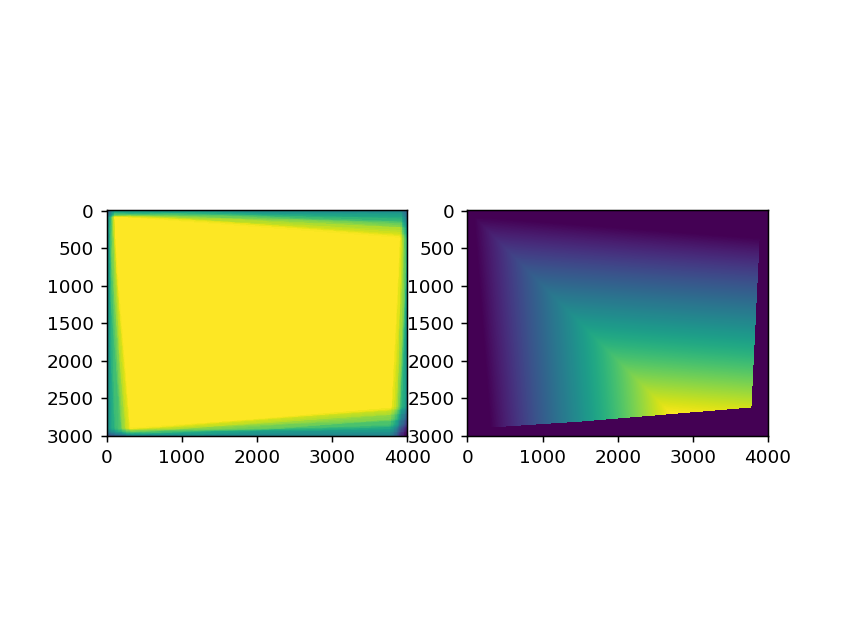

(array([2708, 2708, 2708, 2708, 2708, 2708]), array([2718, 2719, 2720, 2721, 2722, 2723]))
42.5 ms ± 781 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%time sq = nb_square_detection(res==nimg)
fig, ax = subplots(1,2)
ax[0].imshow(res)
ax[1].imshow(sq)
print(numpy.where(sq==sq.max()))
%timeit sq = nb_square_detection(res==nimg)

CPU times: user 8.92 s, sys: 100 ms, total: 9.02 s
Wall time: 9.02 s


<IPython.core.display.Javascript object>


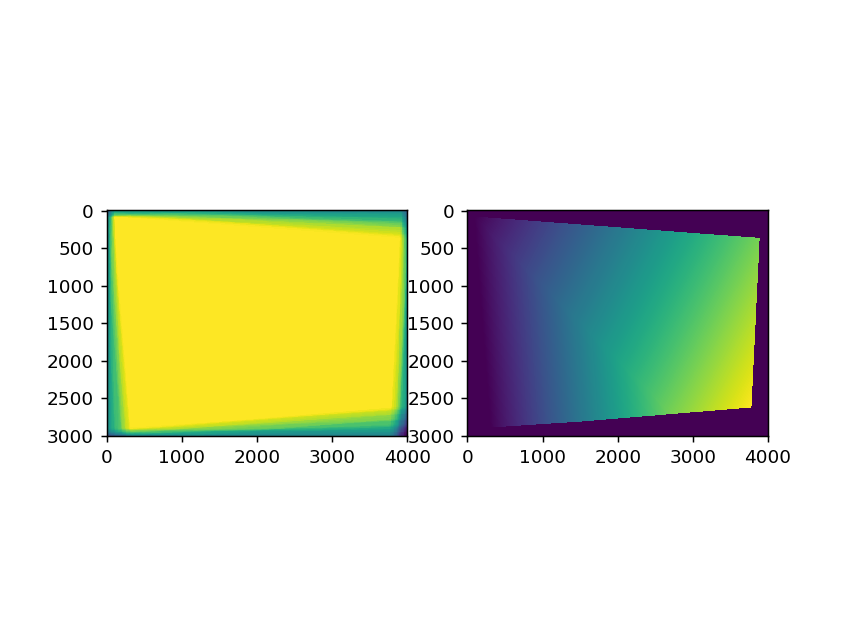

(array([2620]), array([3779]))


In [21]:
ary = (res==nimg)
inp = numpy.ascontiguousarray(ary, numpy.int32)
%time sizes = nb_rectangle_detection(inp)
fig, ax = subplots(1,2)
ax[0].imshow(res)
ax[1].imshow(sizes)
print(numpy.where(sizes==sizes.max()))

In [17]:
%timeit nb_rectangle_detection(ary)

11.3 s ± 92.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
getsize(0,0)